<a href="https://colab.research.google.com/github/Christheoneoneil/csys302_final/blob/main/MOCS_final_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
!pip install mapclassify
!pip install rtree
!pip install geopandas
!pip install osmnx
!pip install momepy

In [ ]:
import collections
import geopandas
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns

#Load Data

In [2]:
try:
  streets_graph = ox.io.load_graphml('/content/btv_20km_streets.graphml')
except FileNotFoundError:
  streets_graph = ox.graph_from_place('Burlington, Vermont',
                                    network_type ='drive',
                                    simplify = True,
                                    retain_all = False,
                                    truncate_by_edge = False,
                                    which_result = None,
                                    buffer_dist = 20000,
                                    clean_periphery = True,
                                    custom_filter = None)
  
  speed_limits = {'motorway' : 104.67,
                'trunk' : 64.3738,
                'primary' : 80.4672,
                'secondary' : 80.4672, 
                'tertiary' : 80.4672, 
                'unclassified' : 80.4672, 
                'residential' : 40.2336, 
                'service' : 40.2336, 
                'motorway_link' : 80.4672, 
                'trunk_link' : 64.3738, 
                'primary_link' : 104.67, 
                'secondary_link' : 104.67, 
                'motorway_junction' : 104.67}

  streets_graph = ox.projection.project_graph(streets_graph)

  streets_graph = ox.speed.add_edge_speeds(G = streets_graph,
                                          hwy_speeds = speed_limits,
                                          fallback = 80.4672,
                                          precision = 4)

  streets_graph = ox.speed.add_edge_travel_times(G = streets_graph,
                                                precision = 2)
  
  ox.io.save_graphml(streets_graph,
                   filepath='/content/btv_20km_streets.graphml',
                   encoding='utf-8')

In [3]:
intersections, streets = ox.graph_to_gdfs(ox.get_undirected(streets_graph),
                                          nodes=True,
                                          edges=True,
                                          node_geometry=True,
                                          fill_edge_geometry=True)

##Stats and EDA

In [ ]:
streets = streets[['osmid',
                   'lanes',
                   'name',
                   'highway',
                   'oneway',
                   'length',
                   'geometry',
                   'speed_kph',
                   'travel_time']]

streets

osmid lanes                  name  \
u           v           key                                           
204349898   204508645   0     579955814     2  East Lakeshore Drive   
            204349908   0      19685280   NaN   Sandy Shore Terrace   
            204425905   0     579955814     2  East Lakeshore Drive   
204508645   204508651   0      19692708   NaN         Tamorac Place   
            204583055   0     579955814     2  East Lakeshore Drive   
...                                 ...   ...                   ...   
10124876753 10124876750 1    1106444087   NaN                   NaN   
10124876749 10124876750 0    1106444086   NaN                   NaN   
10131405973 10131405971 0    1107224746     1      Shelburne Street   
            10131405974 0    1107224743     1      Shelburne Street   
10131405976 10131405974 0    1107224744     1      Shelburne Street   

                                 highway  oneway   length  \
u           v           key                                 
204349898   204508645   0       tertiary   False   15.380   
            204349908   0    residential   False  183.278   
            204425905   0       tertiary   False  272.018   
204508645   204508651   0    residential   False   71.975   
            204583055   0       tertiary   False  445.788   
...                                  ...     ...      ...   
10124876753 10124876750 1    residential   False  142.685   
10124876749 10124876750 0    residential   False   84.457   
10131405973 10131405971 0        primary    True    8.517   
            10131405974 0        primary    True    8.504   
10131405976 10131405974 0        primary    True   17.029   

                                                                      geometry  \
u           v           key                                                      
204349898   204508645   0    LINESTRING (642709.976 4934226.266, 642723.731...   
            204349908   0    LINESTRING (642861.661 4934120.762, 642805.140...   
            204425905   0    LINESTRING (642961.022 4934366.900, 642944.747...   
204508645   204508651   0    LINESTRING (642753.264 4934169.596, 642726.994...   
            204583055   0    LINESTRING (642310.182 4934042.270, 642387.907...   
...                                                                        ...   
10124876753 10124876750 1    LINESTRING (643156.593 4917433.361, 643192.020...   
10124876749 10124876750 0    LINESTRING (643156.593 4917433.361, 643121.950...   
10131405973 10131405971 0    LINESTRING (642579.960 4924925.019, 642576.222...   
            10131405974 0    LINESTRING (642584.673 4924918.066, 642582.870...   
10131405976 10131405974 0    LINESTRING (642579.193 4924903.043, 642582.312...   

                             speed_kph  travel_time  
u           v           key                          
204349898   204508645   0      80.4672         0.69  
            204349908   0      40.2336        16.40  
            204425905   0      80.4672        12.17  
204508645   204508651   0      40.2336         6.44  
            204583055   0      80.4672        19.94  
...                                ...          ...  
10124876753 10124876750 1      40.2336        12.77  
10124876749 10124876750 0      40.2336         7.56  
10131405973 10131405971 0      80.4672         0.38  
            10131405974 0      80.4672         0.38  
10131405976 10131405974 0      80.4672         0.76  

[8525 rows x 9 columns]

In [ ]:
convex_hull = streets.unary_union.convex_hull
area = convex_hull.area
centroid = convex_hull.centroid
stats = ox.basic_stats(streets_graph, area=area)

In [ ]:
stats

{'n': 6743,
 'm': 16377,
 'k_avg': 4.857481833012012,
 'edge_length_total': 4287693.9749999875,
 'edge_length_avg': 261.8119298406294,
 'streets_per_node_avg': 2.5327005783775767,
 'streets_per_node_counts': {0: 0, 1: 1822, 2: 28, 3: 4385, 4: 495, 5: 13},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.27020613970043006,
  2: 0.004152454397152602,
  3: 0.6503040189826487,
  4: 0.0734094616639478,
  5: 0.0019279252558208513},
 'intersection_count': 4921,
 'street_length_total': 2219155.988000009,
 'street_segment_count': 8525,
 'street_length_avg': 260.3115528445759,
 'circuity_avg': 1.1085164069683986,
 'self_loop_proportion': 0.026392961876832845,
 'node_density_km': 5.250070661005211,
 'intersection_density_km': 3.831469334540507,
 'edge_density_km': 3338.3800002248618,
 'street_density_km': 1727.825262463722}

#Route Times and Distances: 15 Random Routes

In [4]:
scale = 15

origin_list = []
dest_list = []

for i in range(scale):
  random_nodes = np.random.choice(intersections.T.columns.values, 2)
  origin_list.append(random_nodes[0])
  dest_list.append(random_nodes[1])

In [5]:
scale = 15

origin_list = list()
dest_list = list()

for i in range(scale):
  random_nodes = np.random.choice(intersections.T.columns.values, 2)
  origin_list.append(random_nodes[0])
  dest_list.append(random_nodes[1])

route_list = list()
color_list = list()
line_width = list()
travel_times = list()
travel_distances = list()

for i in range(scale):
  # Calculate the paths
  route_list.append(nx.dijkstra_path(streets_graph,
                                     source=origin_list[i],
                                     target=dest_list[i],
                                     weight='length'))
  
  route_list.append(nx.dijkstra_path(streets_graph,
                                     source=origin_list[i],
                                     target=dest_list[i],
                                     weight='travel_time_seconds'))

  # Get the actual travel times
  travel_distances.append(nx.dijkstra_path_length(streets_graph,
                                                  source=origin_list[i],
                                                  target=dest_list[i],
                                                  weight='length'))
  
  travel_times.append(nx.dijkstra_path_length(streets_graph,
                                              source=origin_list[i],
                                              target=dest_list[i],
                                              weight='travel_time_seconds'))

  color_list.append('r')
  color_list.append('g')

  line_width.append(0.4)
  line_width.append(0.4)

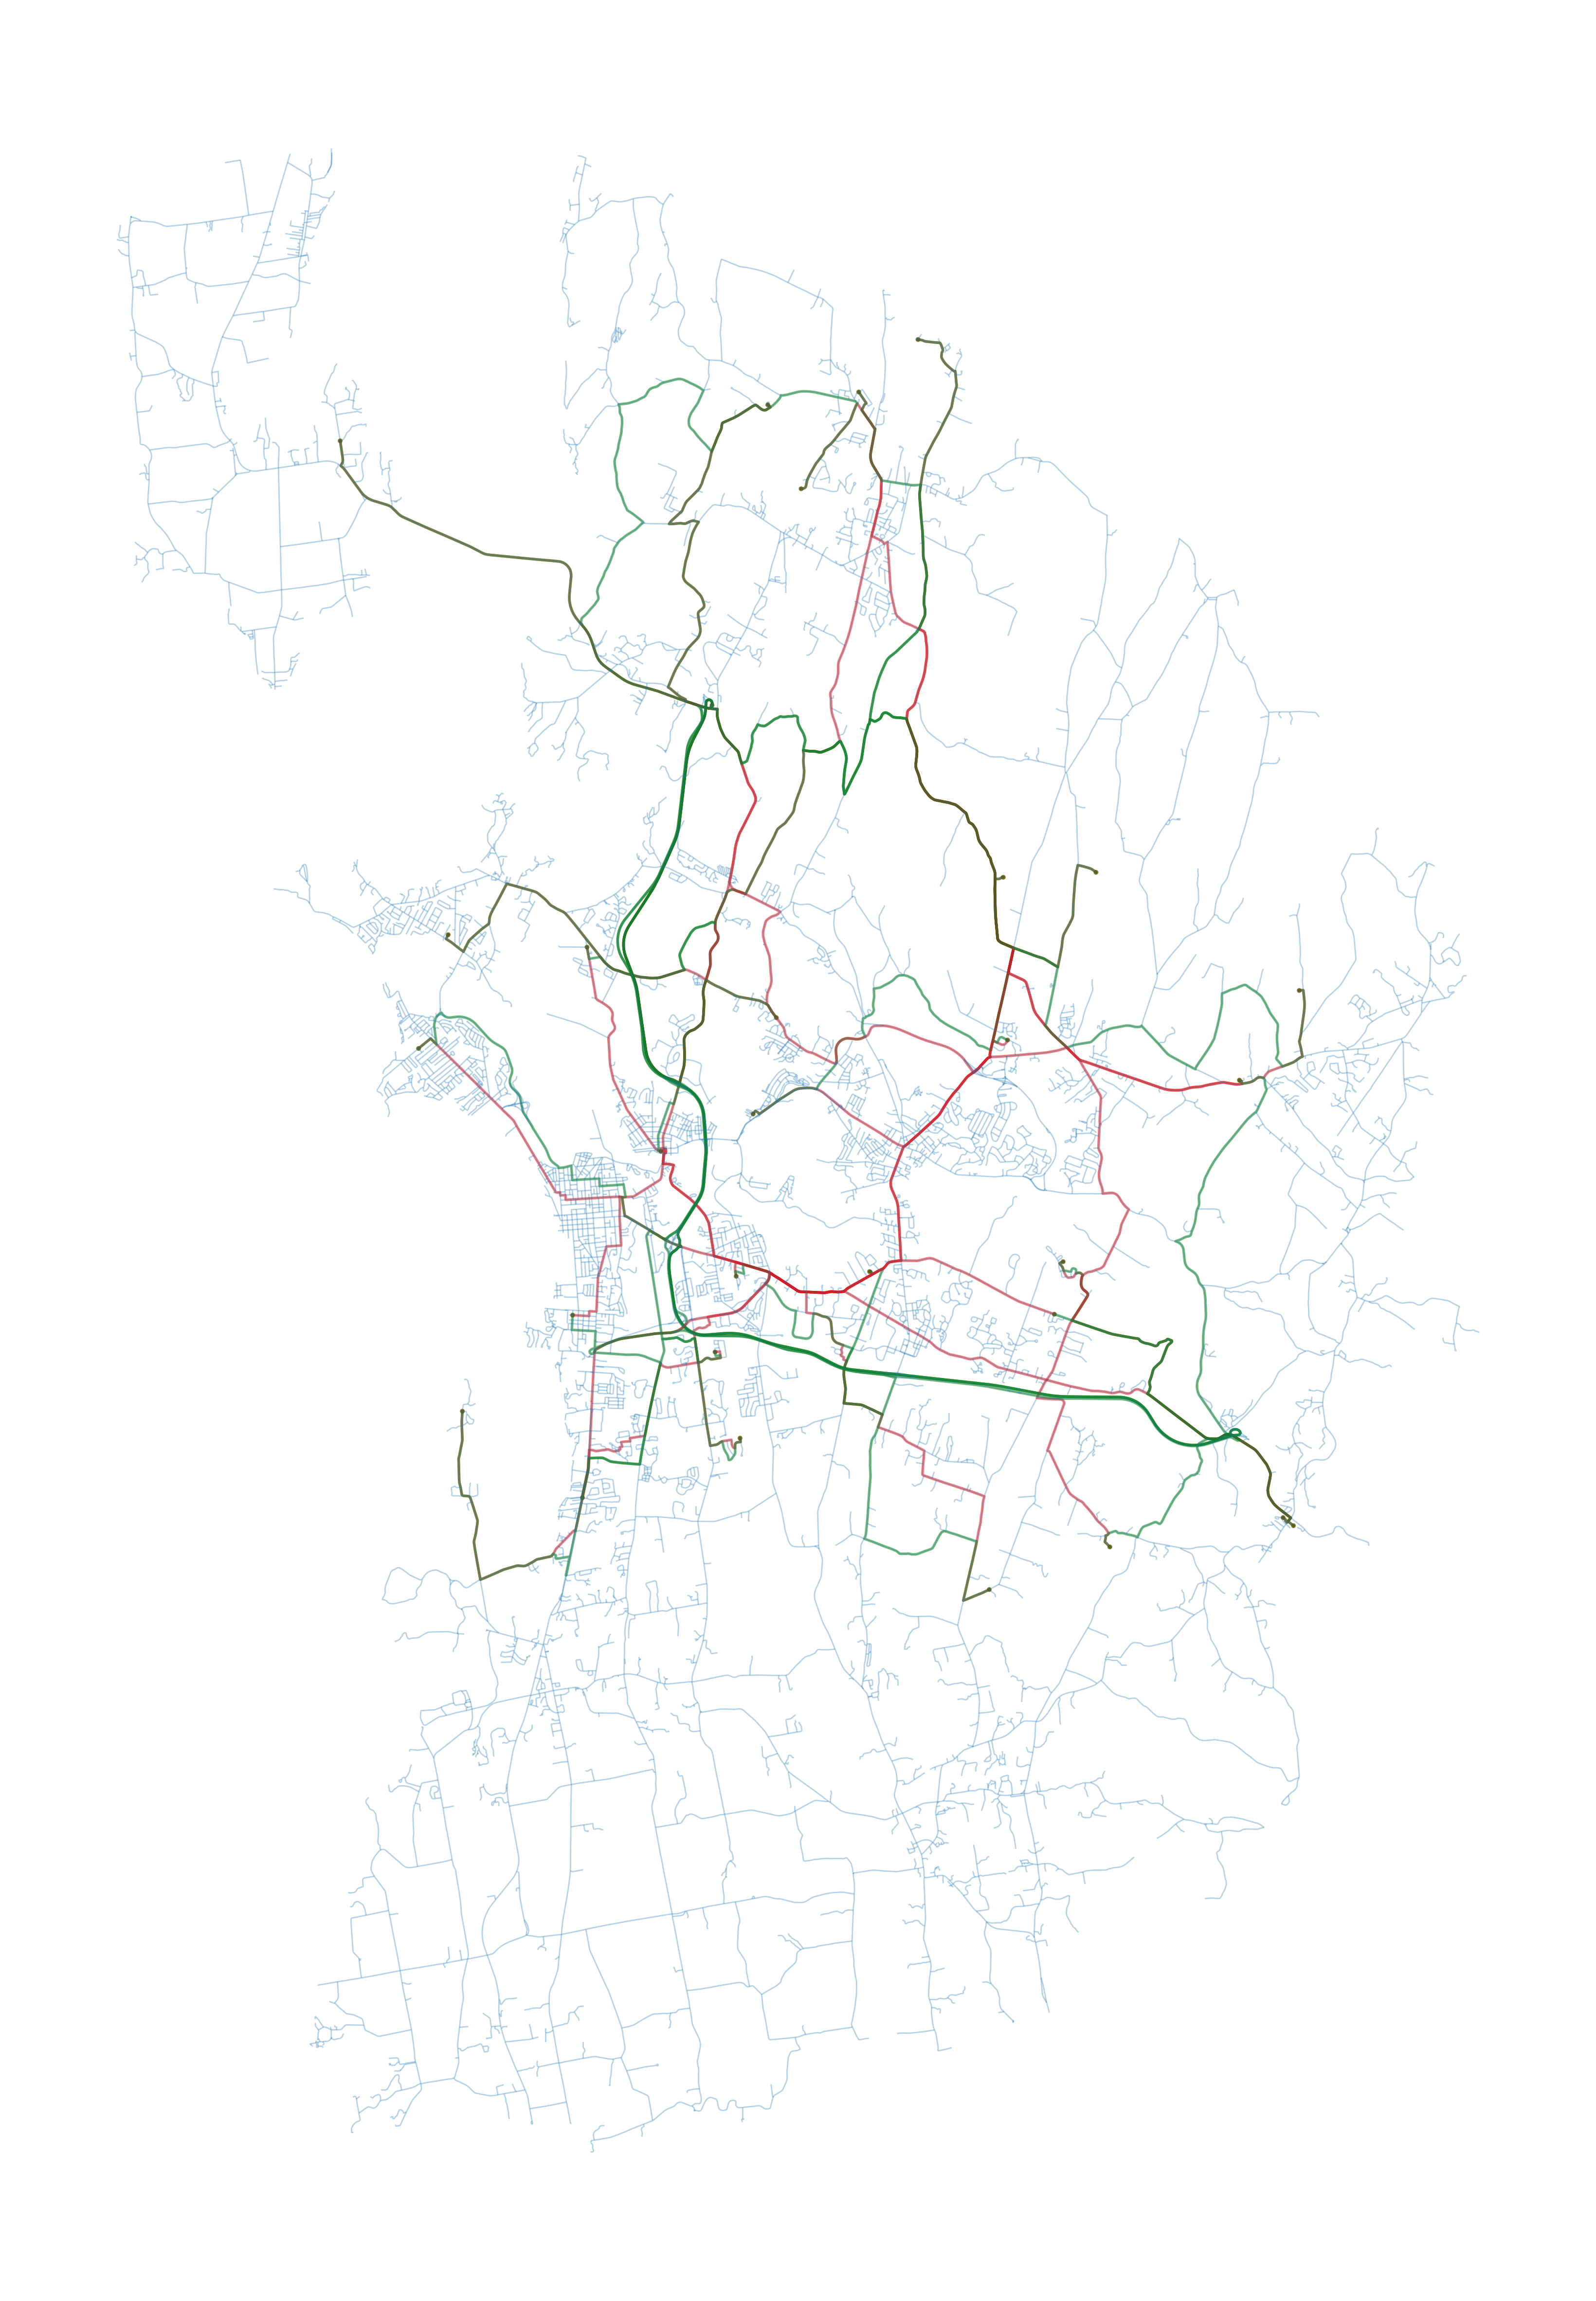

In [6]:
fig, ax = plt.subplots(figsize=(6,6),
                       dpi=1000)

ox.plot.plot_graph_routes(
    streets_graph,
    route_list,
    color_list,
    route_linewidths = line_width,
    ax = ax,
    orig_dest_size = 0.5,
    route_alpha = 0.5,
    figsize=(6, 6),
    bgcolor='w',
    node_color='none', 
    node_size=0, 
    node_alpha=None,
    node_edgecolor='none', 
    node_zorder=1, 
    edge_color='b',
    edge_linewidth=0.3,
    edge_alpha=0.5,
    show=False,
    close=False,
    save=False,
    filepath=None,
    dpi=1000,
    bbox=None,
    facecolor='white',
    transparent=False)
ax = plt.gca()
streets.plot(ax = ax,
             linewidth=0.2,
             k=15,
             alpha=0.33)
ax.set_axis_off()
plt.savefig('fifteen_random_routes.png',
            facecolor='white',
            transparent=False)
plt.show()

In [7]:
route_dist_km = (np.array(travel_distances) / 1000) # Km to Meters
route_times_hour = (np.array(travel_times) / 60)    # Minutes to Hours
route_speeds_kph = route_dist_km / route_times_hour # Km/Hour
route_speeds_kph.mean()                             # Avg. Speed

27.035736200869028

In [8]:
route_dist_km.mean()                                # Mean route length

21.412799866666663

In [9]:
route_times_hour.mean()                             # Mean travel time

0.792222222222222

#Primal Approach

In [ ]:
# Analyze Network
roads = momepy.gdf_to_nx(streets)
roads = momepy.clustering(roads,
                          name='clustering')
roads = momepy.meshedness(roads,
                          radius=5,
                          name='meshedness')

intersections = momepy.nx_to_gdf(roads,
                                 points=True,
                                 lines=False,
                                 spatial_weights=False)

roads = momepy.closeness_centrality(roads,
                                    radius=400,
                                    name='Proximity_400',
                                    distance='length',
                                    weight='length')

roads = momepy.betweenness_centrality(roads,
                                      name='betweenness_metric_n',
                                      mode='nodes',
                                      weight='length')

roads = momepy.betweenness_centrality(roads,
                                      name='betweenness_metric_e',
                                      mode='edges',
                                      weight='length')

roads = momepy.straightness_centrality(roads)

intersections_2 = momepy.nx_to_gdf(roads, lines=False)

  0%|          | 0/6743 [00:00<?, ?it/s]

  0%|          | 0/6743 [00:00<?, ?it/s]

In [ ]:
# Visualize Analysis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))

# Clustering Analysis
ax1.set_axis_off()
ax1.set_title('Node Clustering')
intersections.plot(ax=ax1,
                   column='clustering',
                   markersize=5,
                   legend=True,
                   cmap='magma',
                   scheme='quantiles',
                   alpha=0.5,
                   zorder=2)
streets.plot(ax=ax1,
             color='black',
             alpha=0.35,
             zorder=1)

# Meshedness Analysis
ax2.set_axis_off()
ax2.set_title('Node Meshedness')
intersections.plot(ax=ax2,
           column='meshedness',
           markersize=5,
           legend=True,
           cmap='magma',
           alpha=0.5,
           zorder=2,
           scheme='quantiles')
streets.plot(ax=ax2,
             color='black',
             alpha=0.35,
             zorder=1)

# Proximity Analysis
ax3.set_axis_off()
ax3.set_title('Intersection Proximity')
intersections_2.plot(ax=ax3,
           column='Proximity_400',
           markersize=5,
           cmap='magma',
           scheme='quantiles',
           k=15,
           alpha=0.5,
           zorder=2)
streets.plot(ax=ax3,
             color='black',
             alpha=0.35,
             zorder=1)

plt.show()

In [ ]:
primal = momepy.gdf_to_nx(streets,
                          approach='primal')

primal = momepy.closeness_centrality(primal,
                                     radius=400,
                                     name='closeness400',
                                     distance='mm_len',
                                     weight='mm_len')

primal = momepy.closeness_centrality(primal,
                                     name='closeness_global',
                                     weight='mm_len')

primal = momepy.betweenness_centrality(primal,
                                       name='betweenness_metric_n',
                                       mode='nodes',
                                       weight='mm_len')

primal = momepy.betweenness_centrality(primal,
                                       name='betweenness_metric_e',
                                       mode='edges',
                                       weight='mm_len')

primal = momepy.straightness_centrality(primal)

In [ ]:
momepy.mean_nodes(primal,
                  'straightness')

momepy.mean_nodes(primal,
                  'closeness400')

momepy.mean_nodes(primal,
                  'closeness_global')

momepy.mean_nodes(primal,
                  'betweenness_metric_n')

primal_gdf = momepy.nx_to_gdf(primal,
                              points=False)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,
                                    figsize=(45, 15),
                                    dpi=1000)

primal_gdf.plot(ax=ax1,
                column='straightness',
                cmap='magma_r',
                scheme='quantiles',
                k=15,
                alpha=0.6)
ax1.set_axis_off()
ax1.set_title('straightness')

primal_gdf.plot(ax=ax2,
                column='closeness400',
                cmap='magma_r',
                scheme='quantiles',
                k=15,
                alpha=0.6)
ax2.set_axis_off()
ax2.set_title('closeness400')

primal_gdf.plot(ax=ax3,
                column='betweenness_metric_n',
                cmap='magma_r',
                scheme='quantiles',
                k=15,
                alpha=0.6)
ax3.set_axis_off()
ax3.set_title('betweenness angular')

plt.show()

In [ ]:
fig, ax3 = plt.subplots(1,1,
                        figsize=(8.5, 11),
                        dpi=1000)

primal_gdf.plot(ax=ax3,
                column='straightness',
                cmap='Reds',
                scheme='quantiles',
                k=15,
                alpha=0.33,
                zorder=3)

primal_gdf.plot(ax=ax3,
                column='closeness400',
                cmap='Greens',
                scheme='quantiles',
                k=15,
                alpha=0.33,
                zorder=2)

primal_gdf.plot(ax=ax3,
                column='betweenness_metric_n',
                cmap='Blues',
                scheme='quantiles',
                k=15,
                alpha=0.33,
                zorder=1)

ax3.set_axis_off()
ax3.set_title('   Intersection based averages of Straightness (Red), Closeness (Green), and Betweeness (Blue)   \nProjected onto Roadways within 10 km. of Burlington, VT')

plt.savefig('straightness_closeness_betweeness_btv_10KM_nodebasedmean.png')
plt.show()

#Dual Approach

##Analyze

In [ ]:
dual = momepy.gdf_to_nx(streets,
                        approach='dual')

dual = momepy.closeness_centrality(dual,
                                   radius=5,
                                   name='angcloseness400',
                                   weight='angle')

dual = momepy.closeness_centrality(dual,
                                   name='closeness_global_ang',
                                   weight='angle')

dual = momepy.betweenness_centrality(dual,
                                     name='angbetweenness',
                                     mode='nodes',
                                     weight='angle')

dual_gdf = momepy.nx_to_gdf(dual,
                            points=False)

edges_d = momepy.nx_to_gdf(dual)

##Visualize

###Betweeness

In [ ]:
fig, ax = plt.subplots(1,1,
                       figsize=(12,12),
                       dpi=2000)

dual_gdf.plot(ax=ax,
              column='angbetweenness',
              cmap= 'magma_r',
              scheme='quantiles',
              k=15,
              alpha=0.33,
              zorder=1)
ax.set_axis_off()
plt.savefig('angbetween.png',
            facecolor='white',
            transparent=False)
plt.show()

###Three Measures

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,1,
                        figsize=(45, 15),
                        dpi=1000)

dual_gdf.plot(ax=ax1,
              column='angcloseness400',
              cmap='magma_r',
              scheme='quantiles',
              k=15,
              alpha=0.6)
ax1.set_axis_off()
ax1.set_title('closeness angular 400')

dual_gdf.plot(ax=ax2,
              column='closeness_global_ang',
              cmap='magma_r',
              scheme='quantiles',
              k=15,
              alpha=0.6)
ax2.set_axis_off()
ax2.set_title('closeness angular global')

dual_gdf.plot(ax=ax3,
              column='angbetweenness',
              cmap='magma_r',
              scheme='quantiles',
              k=15,
              alpha=0.6)
ax3.set_axis_off()
ax3.set_title('betweenness angular')

plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,
                       figsize=(8.5, 11),
                       dpi=2000)

dual_gdf.plot(ax=ax,
              column='angcloseness400',
              cmap='Reds',
              scheme='quantiles',
              k=15,
              alpha=0.33,
              zorder=3)

dual_gdf.plot(ax=ax,
              column='closeness_global_ang',
              cmap='Greens',
              scheme='quantiles',
              k=15,
              alpha=0.33,
              zorder=2)

dual_gdf.plot(ax=ax,
              column='angbetweenness',
              cmap='Blues',
              scheme='quantiles',
              k=15,
              alpha=0.33,
              zorder=1)

ax.set_axis_off()
ax.set_title('   Angular Local Closeness (Red), Global Closeness (Green), and Betweeness (Blue)   \nProjected onto Roadways within 10 km. of Burlington, VT')

plt.savefig('angcloseness_globalcloseness_angbetweeness_btv_10KM_nodebasedmean.png')
plt.show()